In [7]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import nltk
from nltk.corpus import stopwords, words
from nltk.metrics.distance import jaccard_distance
from scipy import sparse
from nltk.util import ngrams
from nltk.stem.snowball import SnowballStemmer
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package words to /home/jon/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [119]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [120]:
train_df["mentions_count"] = train_df["text"].apply(lambda x: len([c for c in x if c=="@"]))
test_df["mentions_count"] = test_df["text"].apply(lambda x: len([c for c in x if c=="@"]))
train_df["hashtag_count"] = train_df["text"].apply(lambda x: len([c for c in x if c=="#"]))
test_df["hashtag_count"] = test_df["text"].apply(lambda x: len([c for c in x if c=="#"]))
train_df["exclamation_count"] = train_df["text"].apply(lambda x: len([c for c in x if c=="!"]))
test_df["exclamation_count"] = test_df["text"].apply(lambda x: len([c for c in x if c=="!"]))
train_df["word_count"] = train_df["text"].apply(lambda x: len(x.split()))
test_df["word_count"] = test_df["text"].apply(lambda x: len(x.split()))
train_df["character_count"] = train_df["text"].apply(lambda x: len(x))
test_df["character_count"] = test_df["text"].apply(lambda x: len(x))
train_df["mean_word_length"] = train_df["text"].apply(lambda x: np.mean([len(f) for f in x.split()]))
test_df["mean_word_length"] = test_df["text"].apply(lambda x: np.mean([len(f) for f in x.split()]))
train_df["has_link"] = train_df["text"].apply(lambda x: int(bool(re.search(r'https?',x))))
test_df["has_link"] = test_df["text"].apply(lambda x: int(bool(re.search(r'https?',x))))

In [10]:
with pd.option_context('display.max_colwidth',100):
    display(train_df[train_df.target == 0].head())
    display(train_df[train_df.target == 1].head())

,id,keyword,location,text,target,mentions_count,hashtag_count,exclamation_count,word_count,character_count,mean_word_length,has_link
15,23,NaN,NaN,What's up man?,0,0,0,0,3,14,4.000000,0
16,24,NaN,NaN,I love fruits,0,0,0,0,3,13,3.666667,0
17,25,NaN,NaN,Summer is lovely,0,0,0,0,3,16,4.666667,0
18,26,NaN,NaN,My car is so fast,0,0,0,0,5,17,2.600000,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,0,0,6,3,28,8.666667,0


,id,keyword,location,text,target,mentions_count,hashtag_count,exclamation_count,word_count,character_count,mean_word_length,has_link
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,0,1,0,13,69,4.384615,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,7,38,4.571429,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,0,0,0,22,133,5.090909,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,1,0,8,65,7.125000,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,2,0,16,88,4.500000,0


# Word lengths and word counts (and others)

Simple feature which shows average length of words and number of words in a tweet

In [11]:
train_df[train_df.has_link == 0]["target"].value_counts()

0    2543
1    1099
Name: target, dtype: int64

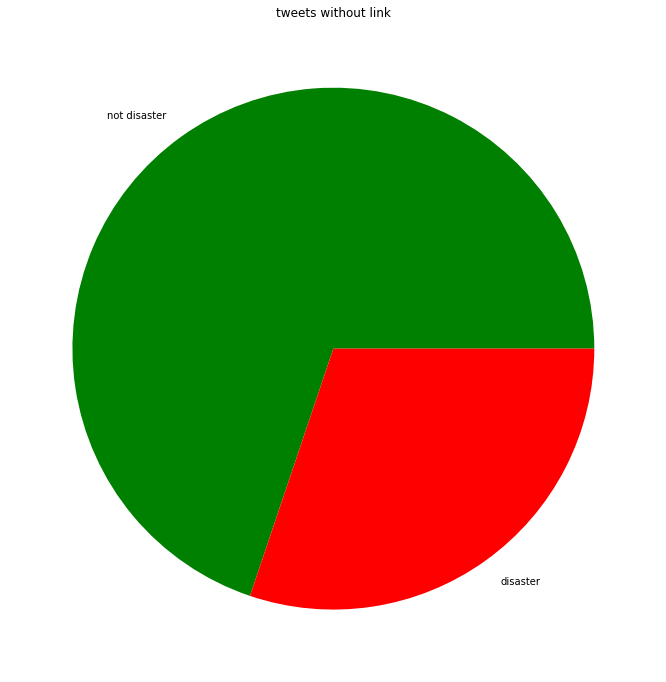

In [116]:
plt.figure(figsize=(20,12))
plt.title("tweets without link")
plt.pie(list(train_df[train_df.has_link == 0]["target"].value_counts()), labels = ["not disaster","disaster"],colors=["green","red"])
plt.savefig("pie1.png",bbox_inches='tight')

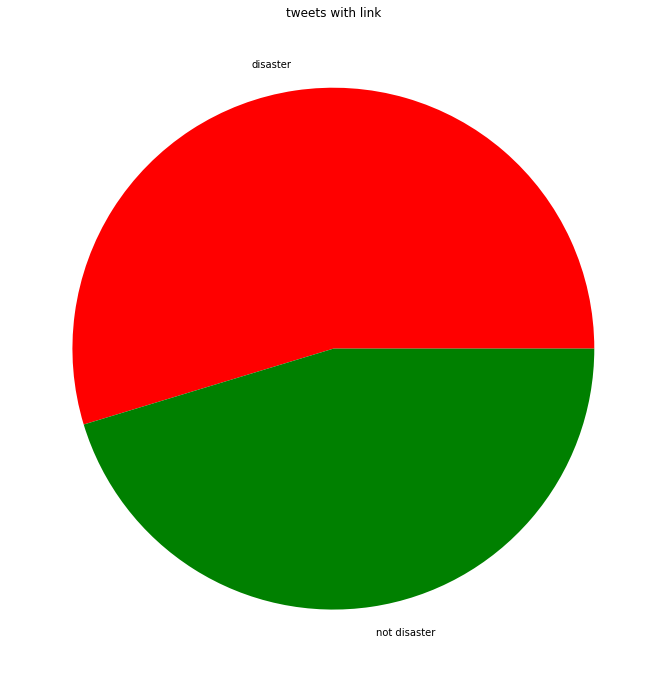

In [117]:
plt.figure(figsize=(20,12))
plt.title("tweets with link")
plt.pie(list(train_df[train_df.has_link == 1]["target"].value_counts()), labels = ["disaster","not disaster"],colors=["red","green"])
plt.savefig("pie2.png",bbox_inches='tight')

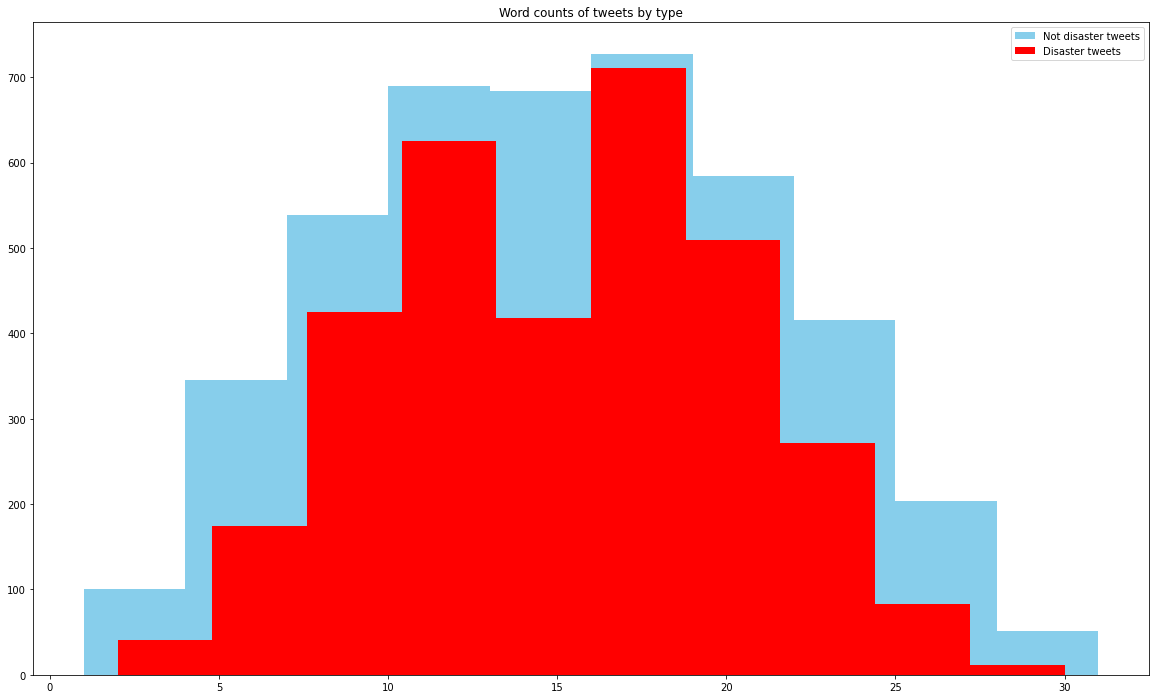

In [121]:
plt.figure(figsize=(20,12))
plt.title("Word counts of tweets by type")
plt.hist(train_df[train_df.target==0]["word_count"],color="skyblue",label="Not disaster tweets")
plt.hist(train_df[train_df.target==1]["word_count"],color="red",label="Disaster tweets")
plt.legend()
plt.savefig("word_counts.png",bbox_inches='tight')

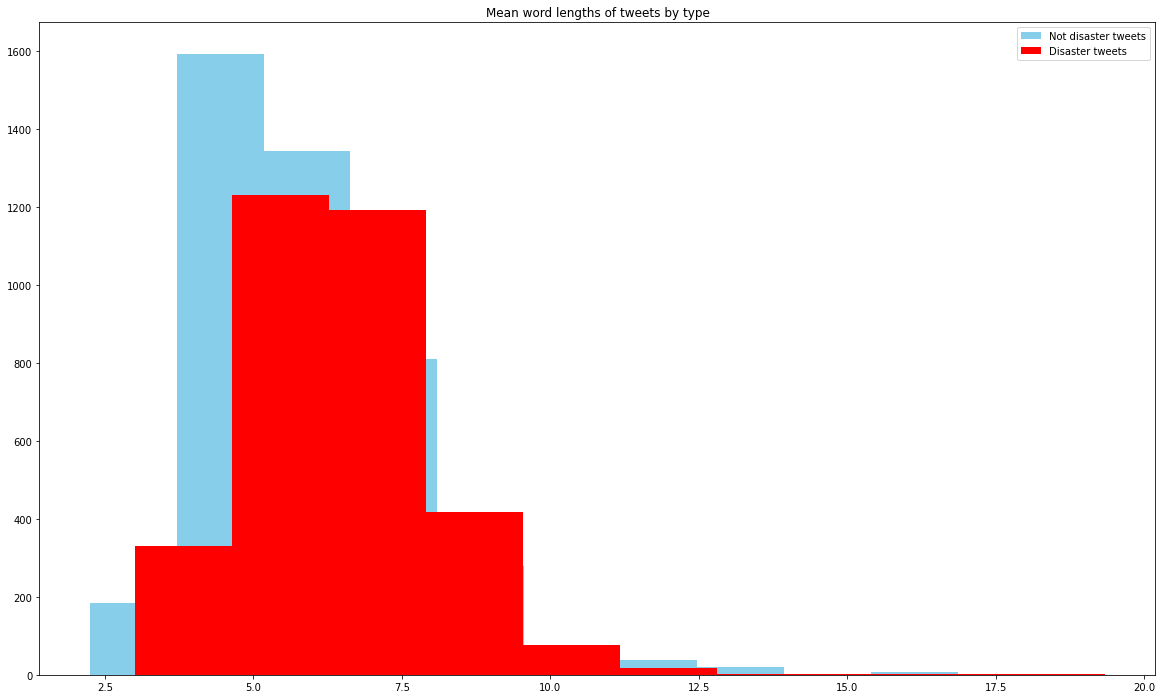

In [122]:
plt.figure(figsize=(20,12))
plt.title("Mean word lengths of tweets by type")
plt.hist(train_df[train_df.target==0]["mean_word_length"],color="skyblue",label="Not disaster tweets")
plt.hist(train_df[train_df.target==1]["mean_word_length"],color="red",label="Disaster tweets")
plt.legend()
plt.savefig("word_lengths.png",bbox_inches='tight')

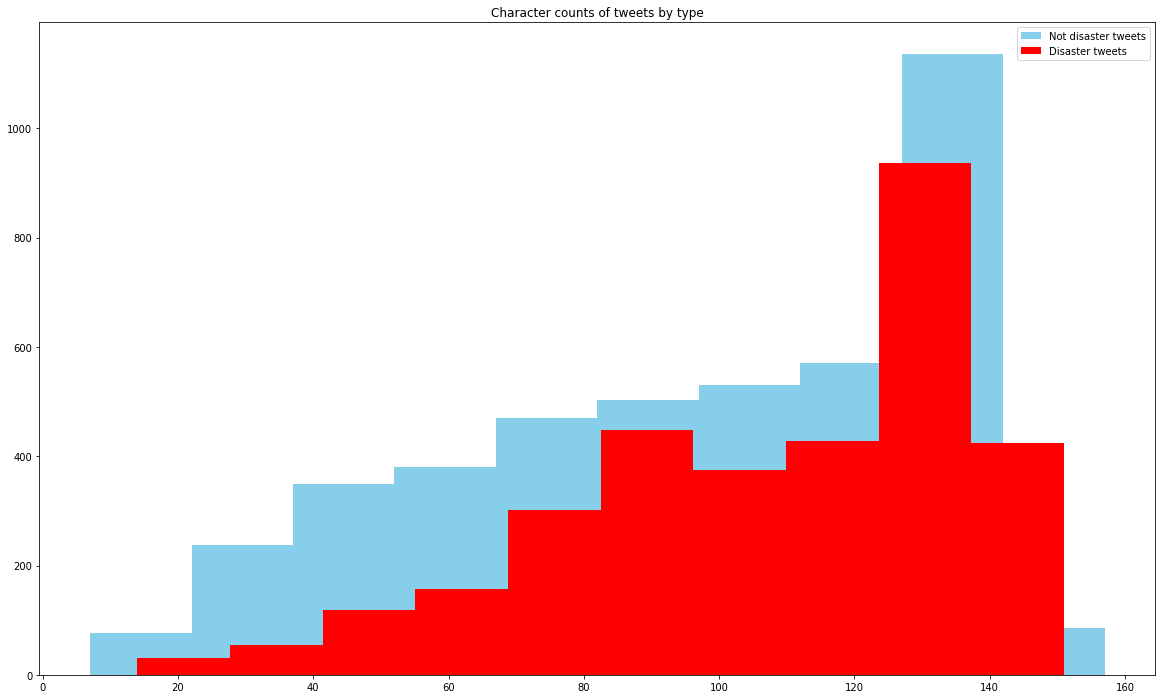

In [123]:
plt.figure(figsize=(20,12))
plt.title("Character counts of tweets by type")
plt.hist(train_df[train_df.target==0]["character_count"],color="skyblue",label="Not disaster tweets")
plt.hist(train_df[train_df.target==1]["character_count"],color="red",label="Disaster tweets")
plt.legend()
plt.savefig("char_counts.png",bbox_inches='tight')

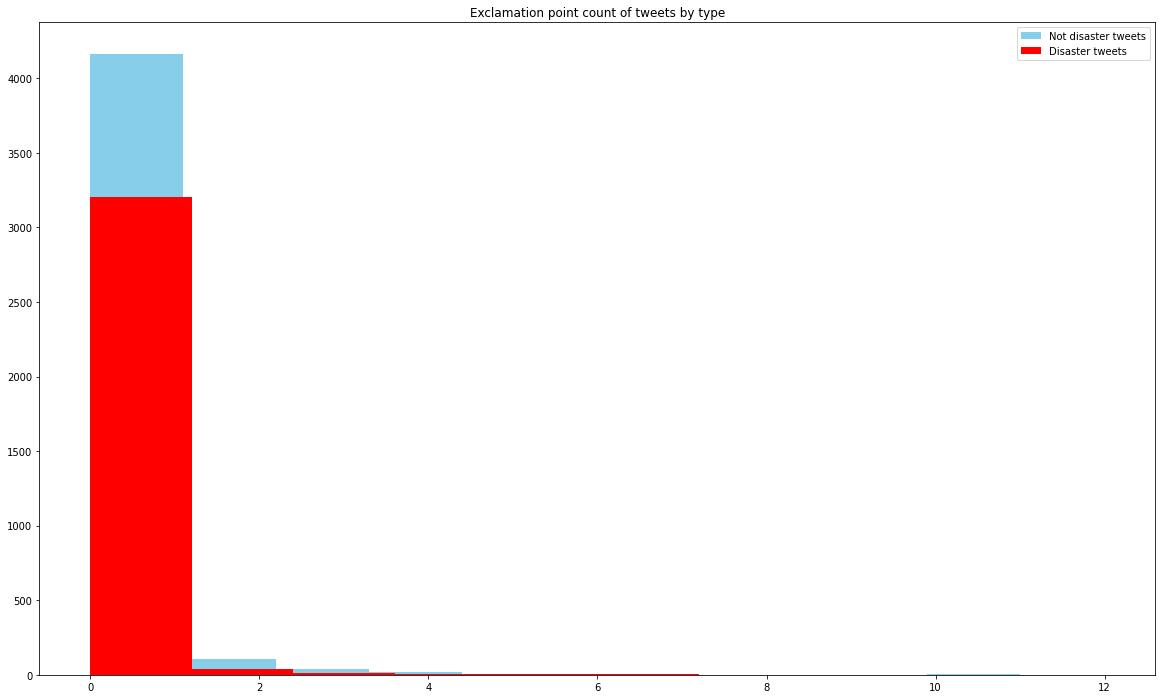

In [124]:
plt.figure(figsize=(20,12))
plt.title("Exclamation point count of tweets by type")
plt.hist(train_df[train_df.target==0]["exclamation_count"],color="skyblue",label="Not disaster tweets")
plt.hist(train_df[train_df.target==1]["exclamation_count"],color="red",label="Disaster tweets")
plt.legend()
plt.savefig("exclamation_count.png",bbox_inches='tight')

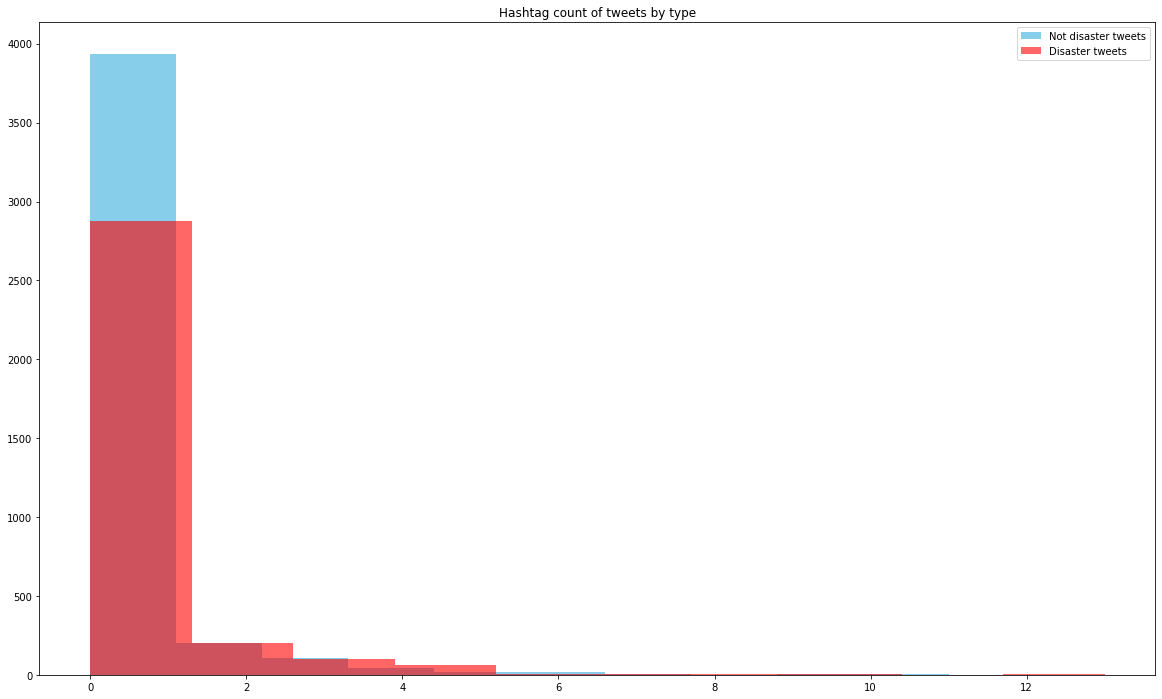

In [125]:
plt.figure(figsize=(20,12))
plt.title("Hashtag count of tweets by type")
plt.hist(train_df[train_df.target==0]["hashtag_count"],color="skyblue",label="Not disaster tweets")
plt.hist(train_df[train_df.target==1]["hashtag_count"],color="red",alpha=0.6,label="Disaster tweets")
plt.legend()
plt.savefig("hashtags.png",bbox_inches='tight')

In [19]:
scoring = {'acc': 'accuracy',
           'f1': 'f1',
           'prec': 'precision'}

In [20]:
classifier0 = linear_model.RidgeClassifier()
scores = model_selection.cross_validate(classifier0,train_df[["has_link","mean_word_length","word_count"]],train_df["target"].values,cv=5,scoring=scoring)

In [21]:
{k:np.mean(v) for k,v in scores.items()}

{'fit_time': 0.023500633239746094,
 'score_time': 0.004368972778320312,
 'test_acc': 0.6264343578058037,
 'test_f1': 0.5815389979943644,
 'test_prec': 0.5615690998020153}

In [22]:
classifier0.fit(train_df[["has_link","mean_word_length","word_count"]],train_df["target"])

RidgeClassifier()

In [23]:
submission_0 = pd.read_csv("sample_submission.csv")
submission_0["target"] = classifier0.predict(test_df[["has_link","mean_word_length","word_count"]])
submission_0.to_csv("submission_0.csv",index=False)

# 1. Vectorizing words

Count all unique words from all training set tweets, and for each tweet, return a vector with the count number of those words.  

In [24]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [25]:
word_vectorizer = feature_extraction.text.CountVectorizer()

In [26]:
english_stopwords = stopwords.words('english')
correct_words = words.words()

In [27]:
def remove_emoji(text):
    #thanks, https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_links(text):
    return re.sub(r'https?://\S+','',text)

In [28]:
from textblob import Word

def correct_word(word):
    the_word = Word(word)
    return the_word.correct()

In [29]:
def strip(word,characters={'.',',','?','!',':',';','#','@','û_','\'','=','>'},special_characters={'(',')','\{','\}','[',']'}):
    word_ = word
    for c in characters:
        word_ = word_.replace(c,'')
    for c in special_characters:
        word_ = word_.replace(c,' ')
    return word_

In [30]:
def lemmatize(text):
    mm0 = strip(text).lower()
    #Correct spelling
    mm1 = " ".join([correct_word(word) for word in mm0.split()])
    #Remove stopwords
    mm2 = " ".join([word for word in mm1.split() if word not in english_stopwords and not bool(re.match("^@",word))])
    return mm2
    

In [31]:
#train_df["text"] = train_df["text"].apply(remove_links).apply(strip)
#test_df["text"] = test_df["text"].apply(remove_links).apply(strip)

In [32]:
lemmatize("These #wildfires are getting out of controll!!!")

'wildfires getting control'

In [33]:
train_vectors = word_vectorizer.fit_transform(train_df["text"])
test_vectors = word_vectorizer.transform(test_df["text"])

In [34]:
train_vectors

<7613x21637 sparse matrix of type '<class 'numpy.int64'>'
	with 111497 stored elements in Compressed Sparse Row format>

In [35]:
classifier1_ridge = linear_model.RidgeClassifier()
scores = model_selection.cross_validate(classifier1_ridge,train_vectors,train_df["target"],cv=5,scoring=scoring)

In [36]:
{k:np.mean(v) for k,v in scores.items()}

{'fit_time': 2.426077938079834,
 'score_time': 0.005473136901855469,
 'test_acc': 0.6672838638036312,
 'test_f1': 0.571038069032355,
 'test_prec': 0.6420542763623762}

In [37]:
{'fit_time': 0.01660013198852539,
 'score_time': 0.003399038314819336,
 'test_acc': 0.7020918841452524,
 'test_f1': 0.5947255945460054,
 'test_prec': 0.7145537366191025}

{'fit_time': 0.01660013198852539,
 'score_time': 0.003399038314819336,
 'test_acc': 0.7020918841452524,
 'test_f1': 0.5947255945460054,
 'test_prec': 0.7145537366191025}

In [38]:
classifier1_ridge.fit(train_vectors,train_df["target"])

RidgeClassifier()

In [39]:
submission_1 = pd.read_csv("sample_submission.csv")
submission_1["target"] = classifier1_ridge.predict(test_vectors)

In [40]:
submission_1.to_csv("submission_1.csv",index=False)

# 2. N-gram analysis

In [41]:
model_1 = feature_extraction.text.CountVectorizer(ngram_range=(1,3),max_features=140)
train_text_1 = model_1.fit_transform(train_df["text"])
test_text_1 = model_1.transform(test_df["text"])

In [42]:
#print(len(test_text_2.toarray()))
#print(len(test_text_1.toarray()))
#train_text_1

In [43]:
classifier1_ridge = linear_model.RidgeClassifier()
scores = model_selection.cross_validate(classifier1_ridge,train_text_1,train_df["target"],cv=5,scoring=scoring)

In [44]:
{k:np.mean(v) for k,v in scores.items()}

{'fit_time': 0.023810291290283205,
 'score_time': 0.0040737628936767575,
 'test_acc': 0.706821207537858,
 'test_f1': 0.6117784604329537,
 'test_prec': 0.7084630111071554}

In [45]:
classifier1_ridge.fit(train_text_1,train_df["target"])
submission_2 = pd.read_csv("sample_submission.csv")
submission_2["target"] = classifier1_ridge.predict(test_text_1)
submission_2.to_csv("submission_ngrams.csv",index=False)

In [46]:
{'fit_time': 0.018644332885742188,
 'score_time': 0.002754974365234375,
 'test_acc': 0.7080025677241559,
 'test_f1': 0.6120115524617807,
 'test_prec': 0.7116133555231692}

{'fit_time': 0.018644332885742188,
 'score_time': 0.002754974365234375,
 'test_acc': 0.7080025677241559,
 'test_f1': 0.6120115524617807,
 'test_prec': 0.7116133555231692}

# N-grams and other features

In [47]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [48]:
def word_with_number(word):
    if word.isdigit():
        return "number"
    else:
        return word

In [49]:
train_df["exclamation_count"] = train_df["text"].apply(lambda x: len([c for c in x if c=="!"]))
test_df["exclamation_count"] = test_df["text"].apply(lambda x: len([c for c in x if c=="!"]))
train_df["has_link"] = train_df["text"].apply(lambda x: int(bool(re.search(r'https?',x))))
test_df["has_link"] = test_df["text"].apply(lambda x: int(bool(re.search(r'https?',x))))
train_df["text"] = train_df["text"].apply(remove_links).apply(strip)
test_df["text"] = test_df["text"].apply(remove_links).apply(strip)
train_df["text"] = train_df["text"].apply(lambda x: " ".join(word_with_number(word).lower() for word in x.split()))
test_df["text"] = test_df["text"].apply(lambda x: " ".join(word_with_number(word).lower() for word in x.split()))

In [50]:
train_df["text"]

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       number people receive wildfires evacuation ord...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610              m194 number utc 5km s of volcano hawaii
7611    police investigating after an e-bike collided ...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [51]:
def merge_features(array,new_feature):
    a = pd.DataFrame(array)
    a = pd.concat([a,new_feature],axis=1)
    return a.values

In [52]:
#vector_model = feature_extraction.text.CountVectorizer(ngram_range=(1,3),max_features=140)
tfid_model = TfidfVectorizer(ngram_range=(1,3),max_features=140)

In [53]:
train_vectors = tfid_model.fit_transform(train_df["text"]).toarray()
test_vectors = tfid_model.transform(test_df["text"]).toarray()

In [54]:
train_vectors = merge_features(train_vectors,train_df[["has_link","exclamation_count"]])
test_vectors = merge_features(test_vectors,test_df[["has_link","exclamation_count"]])

In [55]:
classifier = linear_model.RidgeClassifier()
#classifier = LinearSVC()
#classifier = KNeighborsClassifier(n_neighbors=3,weights='distance')
scores = model_selection.cross_validate(classifier,train_vectors,train_df["target"],cv=5,scoring=scoring)

In [56]:
{k:np.mean(v) for k,v in scores.items()}

{'fit_time': 0.20725197792053224,
 'score_time': 0.023931884765625,
 'test_acc': 0.7129974641998338,
 'test_f1': 0.6230161863715407,
 'test_prec': 0.7126765309348498}

In [57]:
{'fit_time': 0.03480019569396973,
 'score_time': 0.005400609970092773,
 'test_acc': 0.7128660581551557,
 'test_f1': 0.6229085576284399,
 'test_prec': 0.7123946504894322}

{'fit_time': 0.03480019569396973,
 'score_time': 0.005400609970092773,
 'test_acc': 0.7128660581551557,
 'test_f1': 0.6229085576284399,
 'test_prec': 0.7123946504894322}

In [58]:
classifier.fit(train_vectors,train_df["target"])
submission_3 = pd.read_csv("sample_submission.csv")
submission_3["target"] = classifier.predict(test_vectors)
submission_3.to_csv("submission_ngrams_plus.csv",index=False)

# N-grams visual analysis

In [59]:
def get_ngrams_dataframe(X,to_from,max_features=10000):
    vec = feature_extraction.text.CountVectorizer(ngram_range=(to_from[0],to_from[1]),max_features=max_features,stop_words="english").fit(X)
    bag_of_words = vec.transform(X)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0,i]) for word,i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1],reverse=True)
    grams_df = pd.DataFrame(words_freq)
    grams_df.columns=["n_gram","frequency"]
    return grams_df

# Categorical

In [60]:
from nltk import WordNetLemmatizer
from multiprocessing import Pool

In [61]:
wnl = WordNetLemmatizer()
stemmer = SnowballStemmer('english')
def lemmatize(text):
    result = " ".join([wnl.lemmatize(word) for word in text.split()])
    return result

def stem(text):
    result = " ".join([stemmer.stem(word) for word in text.split()])
    return result

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [91]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df["exclamation_count"] = train_df["text"].apply(lambda x: len([c for c in x if c=="!"]))
test_df["exclamation_count"] = test_df["text"].apply(lambda x: len([c for c in x if c=="!"]))
train_df["has_link"] = train_df["text"].apply(lambda x: int(bool(re.search(r'https?',x))))
test_df["has_link"] = test_df["text"].apply(lambda x: int(bool(re.search(r'https?',x))))
train_df["text"] = train_df["text"].apply(lambda x: x.lower()).apply(decontracted)
test_df["text"] = test_df["text"].apply(lambda x: x.lower()).apply(decontracted)
train_df["text"] = train_df["text"].apply(remove_links).apply(strip)
test_df["text"] = test_df["text"].apply(remove_links).apply(strip)
train_df["text"] = train_df["text"].apply(lambda x: " ".join(word_with_number(word).lower() for word in x.split()))
test_df["text"] = test_df["text"].apply(lambda x: " ".join(word_with_number(word).lower() for word in x.split()))
train_df["text"] = train_df["text"].apply(decontracted)
test_df["text"] = test_df["text"].apply(decontracted)
train_df["text"] = train_df["text"].apply(lambda x: " ".join(word for word in x.split() if word not in english_stopwords))
test_df["text"] = test_df["text"].apply(lambda x: " ".join(word for word in x.split() if word not in english_stopwords))
train_df["text"] = train_df["text"].apply(stem)
test_df["text"] = test_df["text"].apply(stem)

In [92]:
train_df

,id,keyword,location,text,target,exclamation_count,has_link
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1,0,0
1,4,NaN,NaN,forest fire near la rong sask canada,1,0,0
2,5,NaN,NaN,resid ask ishelt place notifi offic evacu shel...,1,0,0
3,6,NaN,NaN,number peopl receiv wildfir evacu order califo...,1,0,0
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1,0,0
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane hold bridg collaps nearbi home,1,0,1
7609,10870,NaN,NaN,aria_ahrari thetawniest control wild fire cali...,1,0,0
7610,10871,NaN,NaN,m194 number utc 5km volcano hawaii,1,0,1
7611,10872,NaN,NaN,polic investig e-bik collid car littl portug e...,1,0,0


In [93]:
not_disaster_ngrams = get_ngrams_dataframe(train_df[train_df.target == 0]["text"],(1,2),max_features=140)
disaster_ngrams = get_ngrams_dataframe(train_df[train_df.target == 1]["text"],(1,2),max_features=140)

In [94]:
not_disaster_words = set(not_disaster_ngrams["n_gram"])
disaster_words = set(disaster_ngrams["n_gram"])

In [95]:
#categorical = disaster_words.symmetric_difference(not_disaster_words)
categorical = disaster_words.union(not_disaster_words)
numeric = ['exclamation_count','has_link']

In [96]:
categorical.update(['nsfw','dance','aftershock','zombie','fan army','ebay','armageddon','battle','game','police','girlfriend','earthquake','flood','wildfire'])
categorical = list(categorical)

In [97]:
for category in categorical:
    train_df[f"{category}"] = train_df["text"].apply(lambda x: 1 if category in x else 0)
    test_df[f"{category}"] = test_df["text"].apply(lambda x: 1 if category in x else 0)

/tmp/ipykernel_109165/1523942222.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[f"{category}"] = test_df["text"].apply(lambda x: 1 if category in x else 0)
/tmp/ipykernel_109165/1523942222.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f"{category}"] = train_df["text"].apply(lambda x: 1 if category in x else 0)


In [98]:
train_df[categorical].shape

(7613, 244)

In [99]:
classifier = linear_model.RidgeClassifier()
scores = model_selection.cross_validate(classifier,train_df[categorical].values,train_df["target"],cv=5,scoring=scoring)
{k:np.mean(v) for k,v in scores.items()}

{'fit_time': 0.2567569732666016,
 'score_time': 0.02324090003967285,
 'test_acc': 0.6488971124319781,
 'test_f1': 0.5691260180712486,
 'test_prec': 0.6148224563620278}

# Neural Network

In [100]:
def plot_loss(loss,val_loss):
    plt.figure()
    plt.plot(loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.title("Loss/Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    #plt.ylim(0,0.01)
    plt.legend()
    plt.show()

In [101]:
from keras.models import Sequential,Functional
from keras.layers import Dense,Input,Dropout,BatchNormalization,RNN,SimpleRNN,LSTM,GRU,Embedding,Conv1D,MaxPool1D,SpatialDropout1D,Bidirectional,Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics,Model
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

In [102]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df["text"])
numeric_sequences = train_df["text"].apply(tokenizer.texts_to_sequences)
numeric_sequences_test = test_df["text"].apply(tokenizer.texts_to_sequences)
numeric_sequences = numeric_sequences.apply(lambda x: [e[0] for e in x if e])
numeric_sequences_test = numeric_sequences_test.apply(lambda x: [e[0] for e in x if e])
max_length = max([len(a) for a in numeric_sequences])
padded_sequences = pad_sequences(numeric_sequences,max_length,padding='post')
padded_sequences_test = pad_sequences(numeric_sequences_test,max_length,padding='post')
train_df["padded_sequences"] = pd.Series(map(lambda x: [x],padded_sequences)).apply(lambda x:x[0])
test_df["padded_sequences"] = pd.Series(map(lambda x: [x],padded_sequences_test)).apply(lambda x:x[0])
vocabulary_length = len(tokenizer.word_index) +1

/tmp/ipykernel_109165/470545172.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df["padded_sequences"] = pd.Series(map(lambda x: [x],padded_sequences_test)).apply(lambda x:x[0])


In [103]:
embeddings_dictionary = dict()
embedding_dim = 200
with open("glove.6B.200d.txt") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dim = np.asarray(records[1:],dtype='float32')
        embeddings_dictionary[word] = vector_dim

In [104]:
embedding_matrix = np.zeros((vocabulary_length,embedding_dim))
for word,index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [105]:
embedding_matrix.shape

(14578, 200)

In [106]:
def train_test(dataframe,train_share=0.7,keyword=categorical):
    X = dataframe[keyword]
    y = dataframe["target"]
    train_size = int(train_share*dataframe.shape[0])
    X_train = X[0:train_size].values
    y_train = y[0:train_size].values
    X_test = X[train_size:].values
    y_test = y[train_size:].values
    return X_train,y_train,X_test,y_test

In [107]:
def fix_because_numpy_sucks(array):
    return np.array(list(list(e) for e in array))

In [108]:
set(train_df.columns).symmetric_difference(set(test_df.columns))

{'target'}

In [109]:
X_train_padded,y_train,X_test_padded,y_test = train_test(train_df,train_share=0.9,keyword="padded_sequences")
#X_train,y_train,X_test,y_test = train_test(train_df)

X_train_padded = fix_because_numpy_sucks(X_train_padded)
X_test_padded = fix_because_numpy_sucks(X_test_padded)

In [110]:
actual_padded = fix_because_numpy_sucks(test_df["padded_sequences"].values)
actual_categorical = test_df[categorical+numeric].values

In [111]:
X_train_categorical,_,X_test_categorical,_ = train_test(train_df,train_share=0.9,keyword=categorical+numeric)

In [112]:
X_train_categorical

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [113]:
input_padded = Input(shape=(X_train_padded.shape[1],),name="Padded input")
input_categorical = Input(shape=(X_train_categorical.shape[1],),name="Categorical input")
embedding = Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1],input_length=max_length,embeddings_initializer=Constant(embedding_matrix),name="embedding",trainable=False)(input_padded)
conv_1 = Conv1D(32, kernel_size=3,padding="same",name="1D-convolution")(embedding)
bn_1 = BatchNormalization(name="b.norm.")(conv_1)
drop_1 = Dropout(0.2,name="dropout1")(bn_1)
dense_em = Dense(embedding_matrix.shape[1],name="denseEM",activation="relu")(drop_1)
drop_2 = Dropout(0.2,name="dropout2")(dense_em)
lstm_1 = Bidirectional(LSTM(64,return_sequences=True,dropout=0.1,recurrent_dropout=0.1,kernel_initializer='orthogonal',name='lstm1'))(drop_2)
gru_1 = GRU(64,return_sequences=False,dropout=0.1,recurrent_dropout=0.1,kernel_initializer="orthogonal",name="gru1")(lstm_1)
concatenate = Concatenate()([gru_1,input_categorical])
bn_2 = BatchNormalization(name="b.norm.2")(concatenate)
dense_1 = Dense(64, name="dense64",activation="relu")(bn_2)
drop_3 = Dropout(0.2,name="dropout3")(dense_1)
dense_2 = Dense(32, name="dense32",activation="relu")(drop_3)
dense_3 = Dense(16, name="dense16",activation="relu")(dense_2)
output = Dense(1, name="output",activation="sigmoid")(dense_3)
early_stop = EarlyStopping(monitor='val_loss',patience=70,restore_best_weights=True)


nn_model = Functional(inputs=[input_padded,input_categorical],outputs=output)
nn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])
nn_model_history = nn_model.fit([X_train_padded,X_train_categorical],y_train,validation_split=0.25,epochs=200,verbose=2,callbacks=[early_stop])

Epoch 1/200
161/161 - 38s - loss: 0.6315 - binary_accuracy: 0.6436 - val_loss: 0.5968 - val_binary_accuracy: 0.7262
Epoch 2/200
161/161 - 33s - loss: 0.5425 - binary_accuracy: 0.7291 - val_loss: 0.5275 - val_binary_accuracy: 0.7350
Epoch 3/200
161/161 - 35s - loss: 0.5111 - binary_accuracy: 0.7443 - val_loss: 0.6661 - val_binary_accuracy: 0.6988
Epoch 4/200
161/161 - 36s - loss: 0.4935 - binary_accuracy: 0.7622 - val_loss: 0.6092 - val_binary_accuracy: 0.7449
Epoch 5/200
161/161 - 35s - loss: 0.4766 - binary_accuracy: 0.7731 - val_loss: 0.7346 - val_binary_accuracy: 0.7145
Epoch 6/200
161/161 - 35s - loss: 0.4639 - binary_accuracy: 0.7772 - val_loss: 0.8765 - val_binary_accuracy: 0.7081
Epoch 7/200
161/161 - 36s - loss: 0.4575 - binary_accuracy: 0.7818 - val_loss: 0.7942 - val_binary_accuracy: 0.7513
Epoch 8/200
161/161 - 35s - loss: 0.4388 - binary_accuracy: 0.7927 - val_loss: 0.7764 - val_binary_accuracy: 0.7507
Epoch 9/200
161/161 - 35s - loss: 0.4257 - binary_accuracy: 0.7997 - val

161/161 - 35s - loss: 0.1579 - binary_accuracy: 0.9340 - val_loss: 3.3866 - val_binary_accuracy: 0.7023
Epoch 72/200
161/161 - 36s - loss: 0.1592 - binary_accuracy: 0.9319 - val_loss: 3.3325 - val_binary_accuracy: 0.7128


In [114]:
y_train_pred = nn_model.predict([X_train_padded,X_train_categorical])
y_test_pred = nn_model.predict([X_test_padded,X_test_categorical])
y_train_pred = np.where(y_train_pred.flatten()>0.50,1,0)
y_test_pred = np.where(y_test_pred.flatten()>0.50,1,0)
print("TRAIN ACCURACY: "+str(accuracy_score(y_train,y_train_pred)))
print("TEST ACCURACY: "+str(accuracy_score(y_test,y_test_pred)))

TRAIN ACCURACY: 0.7613487082177784
TEST ACCURACY: 0.7598425196850394


In [115]:
classifier.fit(train_vectors,train_df["target"])
submission_NN = pd.read_csv("sample_submission.csv")
submission_NN["target"] = np.where(nn_model.predict([actual_padded,actual_categorical]).flatten()>0.5,1,0)
submission_NN.to_csv("submission_final?.csv",index=False)

In [721]:
#Neural network without padded
#TRAIN ACCURACY: 0.7695627697504223
#TEST ACCURACY: 0.7202276707530648

In [637]:
#Neural network with padded
#TRAIN ACCURACY: 0.726215049727904
#TEST ACCURACY: 0.7267950963222417

In [654]:
#Neural network with padded and embedding
#TRAIN ACCURACY: 0.7650591105273035
#TEST ACCURACY: 0.7342381786339754

In [ ]:
#Neural network with padded, embedding and dropout
#TRAIN ACCURACY: 0.7382248076562207
#TEST ACCURACY: 0.7469352014010507

In [ ]:
#Neural network with padded, embedding and dropout using 90% of its power
#TRAIN ACCURACY: 0.7534666472047876
#TEST ACCURACY: 0.7637795275590551

In [748]:
#Using a larger copy of union words
#TRAIN ACCURACY: 0.8270325499927018
#TEST ACCURACY: 0.7611548556430446

In [ ]:
#Using union instead of symetric difference
#TRAIN ACCURACY: 0.784265070792585
#TEST ACCURACY: 0.7506561679790026

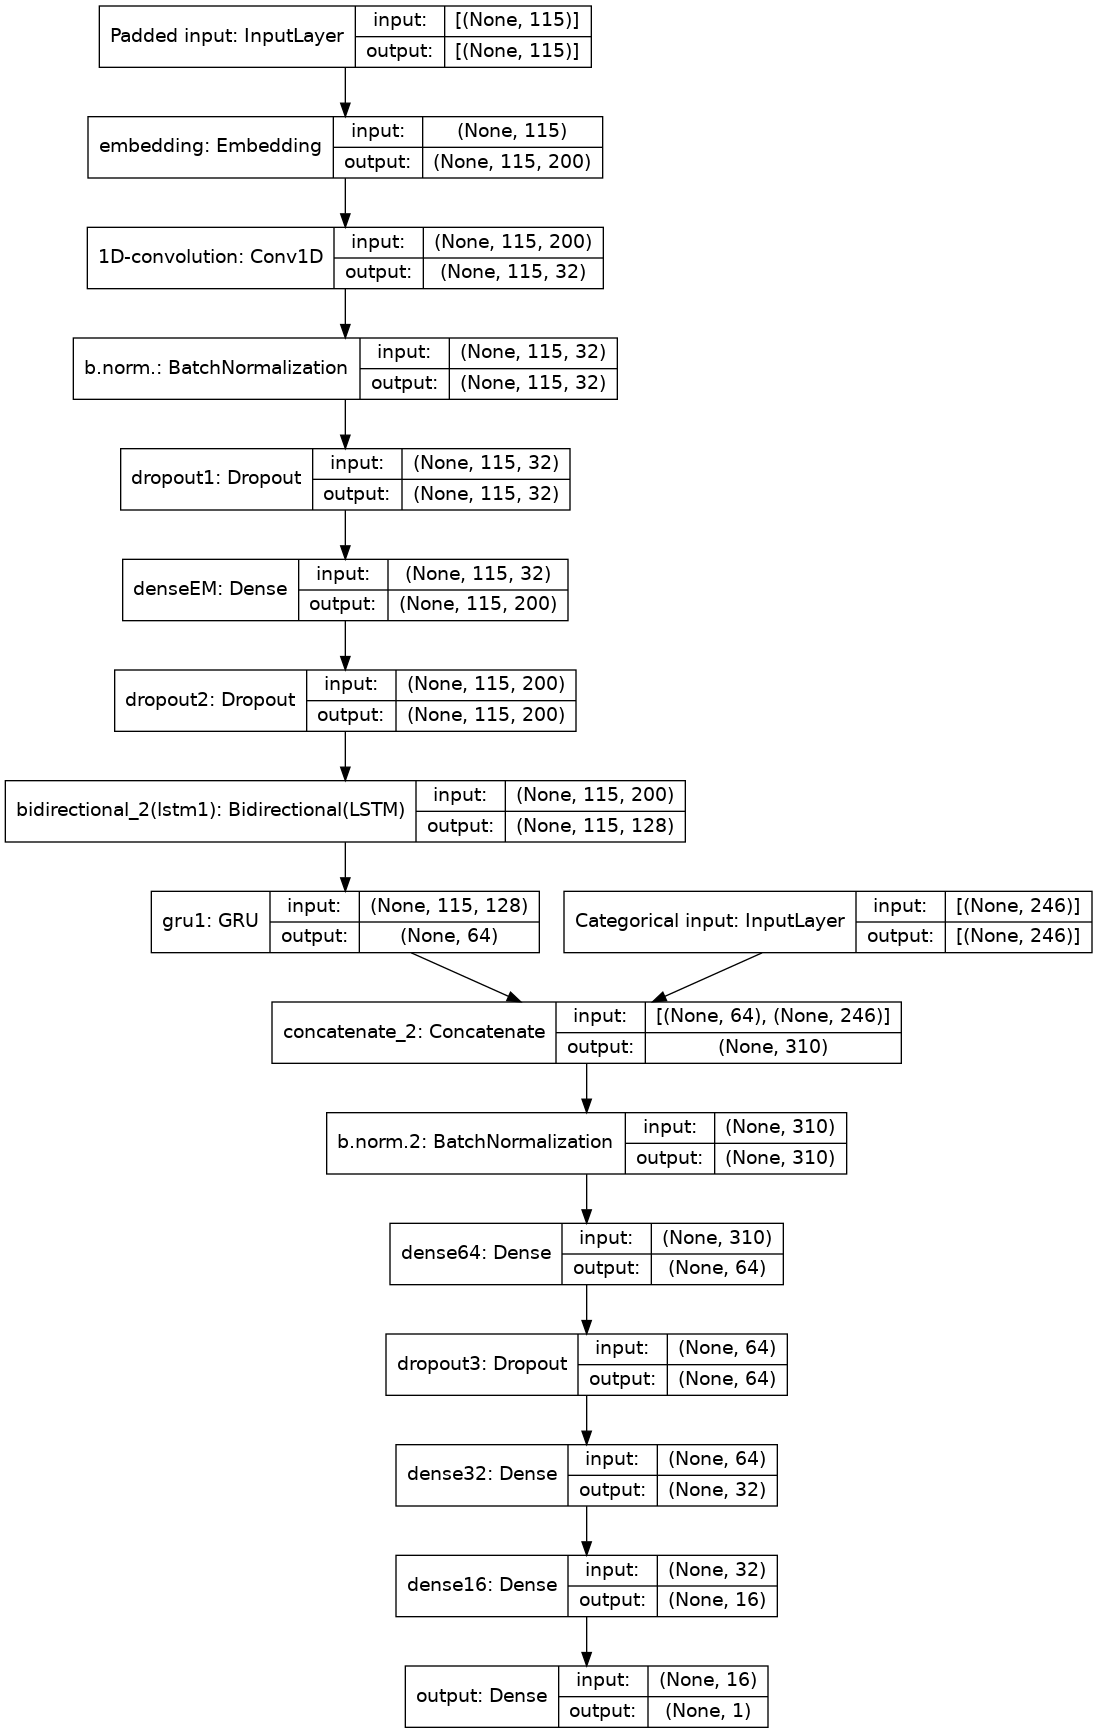

In [127]:
plot_model(nn_model,show_shapes=True,to_file="model.png")

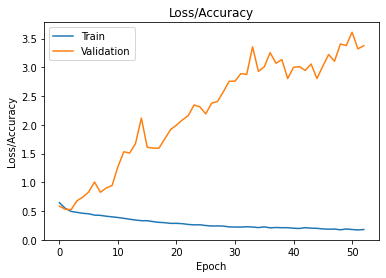

In [88]:
plot_loss(nn_model_history.history['loss'],nn_model_history.history['val_loss'])

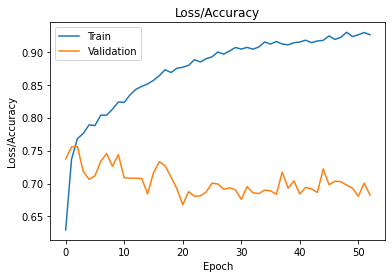

In [89]:
plot_loss(nn_model_history.history['binary_accuracy'],nn_model_history.history['val_binary_accuracy'])